In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import cv2
from sklearn import preprocessing
import random
import tensorflow as tf

In [2]:
len(os.listdir("../input/ocular-disease-recognition-odir5k/preprocessed_images"))

6392

In [3]:
df = pd.read_csv("../input/ocular-disease-recognition-odir5k/full_df.csv")
df.head()

,ID,Patient Age,Patient Sex,Left-Fundus,Right-Fundus,Left-Diagnostic Keywords,Right-Diagnostic Keywords,N,D,G,C,A,H,M,O,filepath,labels,target,filename
0,0,69,Female,0_left.jpg,0_right.jpg,cataract,normal fundus,0,0,0,1,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['N'],"[1, 0, 0, 0, 0, 0, 0, 0]",0_right.jpg
1,1,57,Male,1_left.jpg,1_right.jpg,normal fundus,normal fundus,1,0,0,0,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['N'],"[1, 0, 0, 0, 0, 0, 0, 0]",1_right.jpg
2,2,42,Male,2_left.jpg,2_right.jpg,laser spot，moderate non proliferative retinopathy,moderate non proliferative retinopathy,0,1,0,0,0,0,0,1,../input/ocular-disease-recognition-odir5k/ODI...,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",2_right.jpg
3,4,53,Male,4_left.jpg,4_right.jpg,macular epiretinal membrane,mild nonproliferative retinopathy,0,1,0,0,0,0,0,1,../input/ocular-disease-recognition-odir5k/ODI...,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",4_right.jpg
4,5,50,Female,5_left.jpg,5_right.jpg,moderate non proliferative retinopathy,moderate non proliferative retinopathy,0,1,0,0,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",5_right.jpg


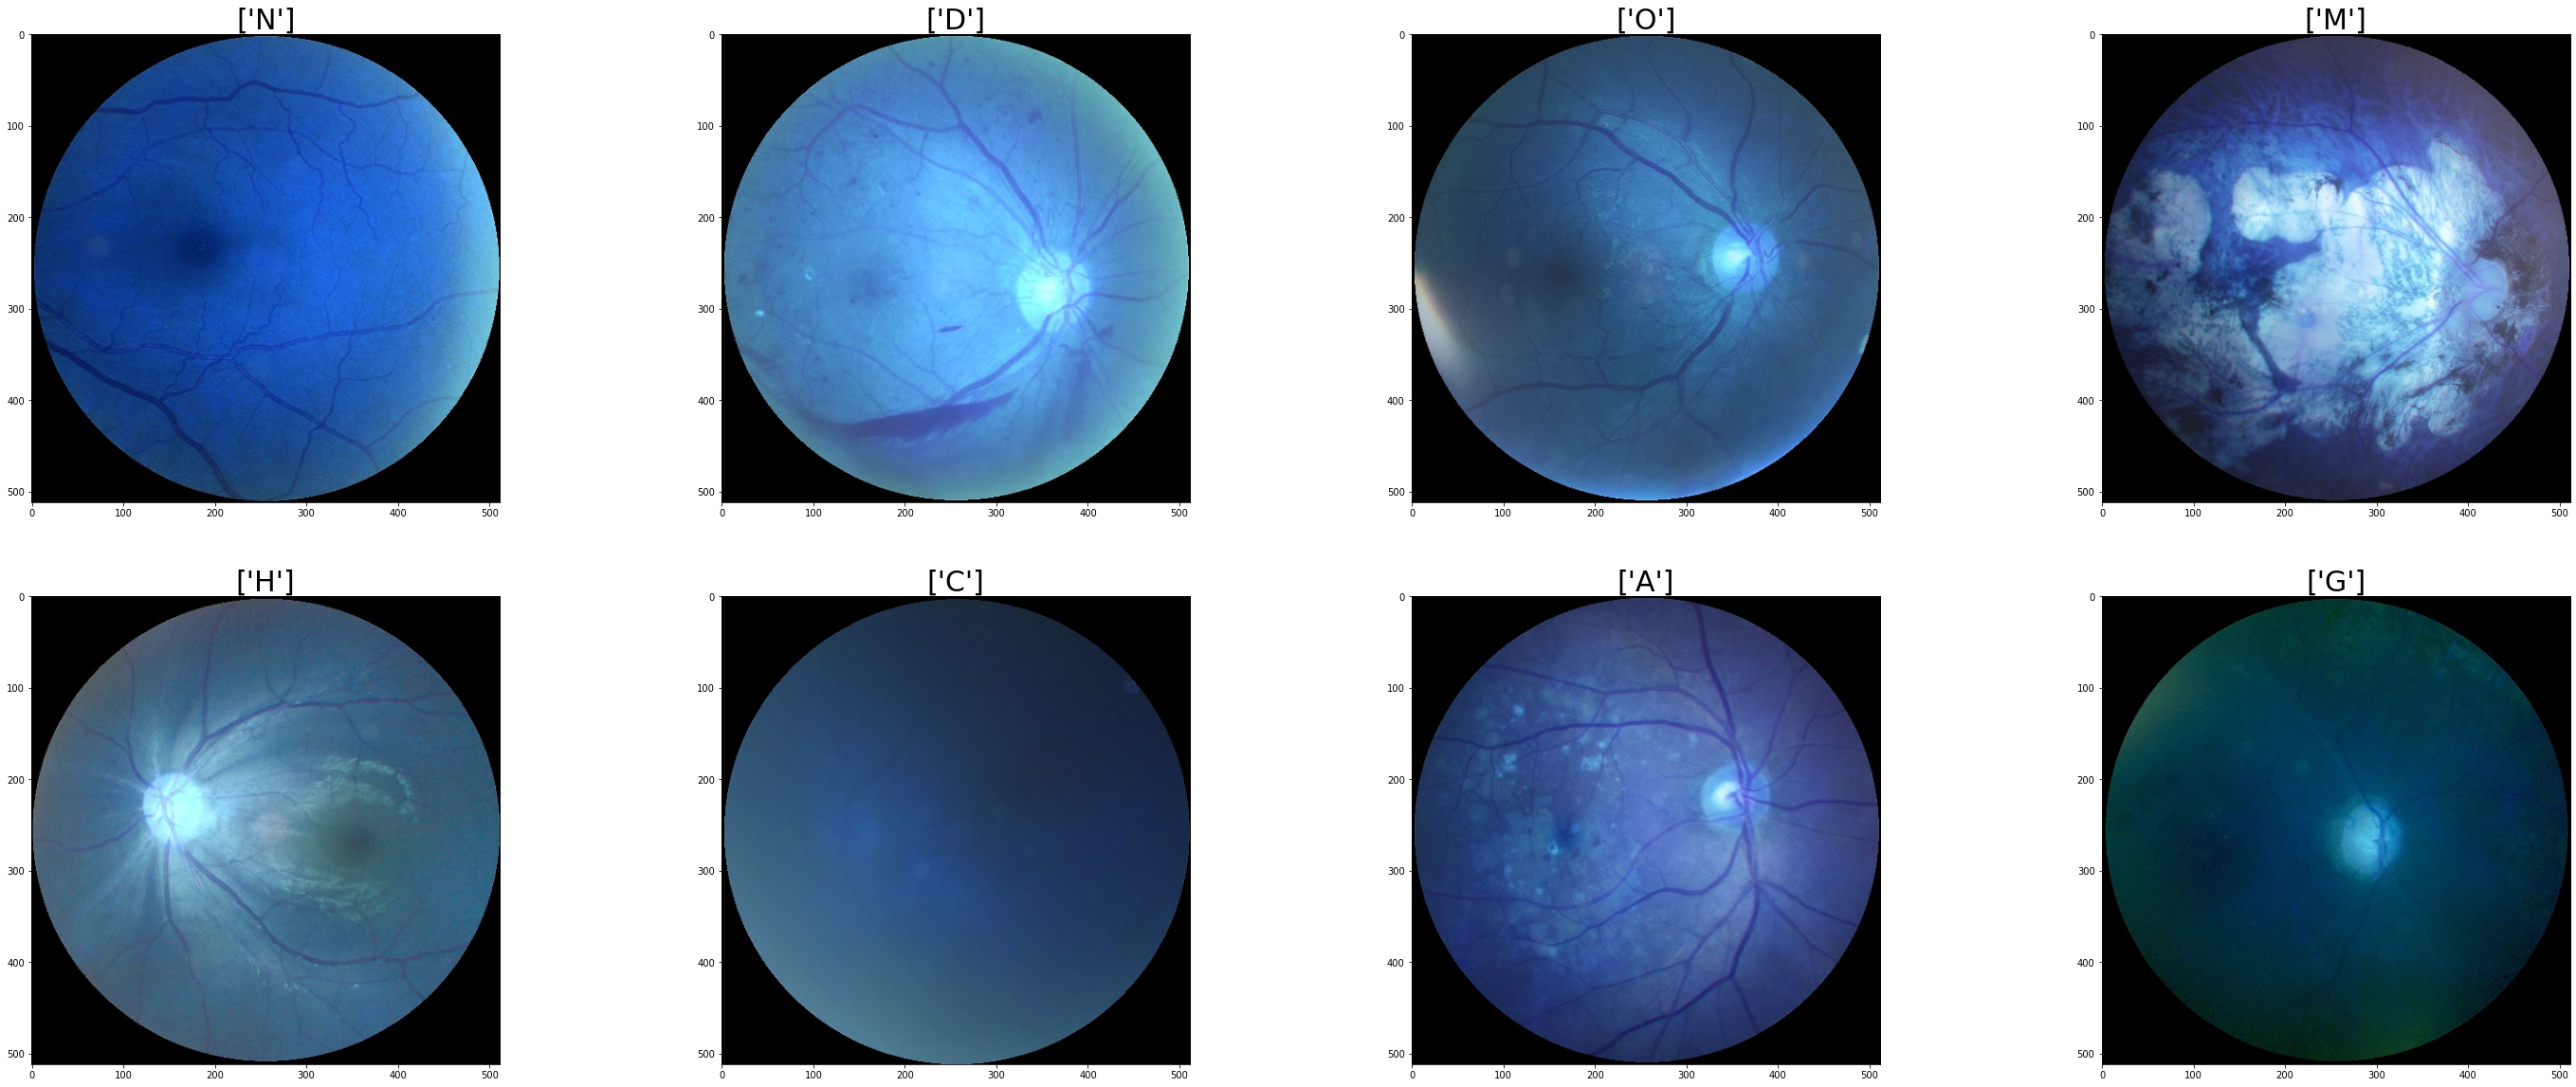

In [4]:
count = 1
f = plt.figure(figsize=(50,20))
for Class in df['labels'].unique():
    seg = df[df['labels']==Class]
    address = seg.sample().iloc[0]['filename']
    dataset_dir = "/kaggle/input/ocular-disease-recognition-odir5k/preprocessed_images/"
    img = cv2.imread(dataset_dir+ address)
    #print(img)
    ax = f.add_subplot(2, 4,count)
    ax = plt.imshow(img)
    ax = plt.title(Class,fontsize= 30)
    count = count + 1
plt.show()

In [5]:
def has_cataract(text):
    if "cataract" in text:
        return 1
    else:
        return 0

In [6]:
df["left_cataract"] = df["Left-Diagnostic Keywords"].apply(lambda x: has_cataract(x))
df["right_cataract"] = df["Right-Diagnostic Keywords"].apply(lambda x: has_cataract(x))

In [7]:
left_cataract_imgs = []
right_cataract_imgs = []
for i in range(len(df)):
    if df["left_cataract"][i] == 1:
        left_cataract_imgs.append(df['Left-Fundus'][i])
    if df["right_cataract"][i] == 1:
        right_cataract_imgs.append(df['Right-Fundus'][i])

In [8]:
print(len(left_cataract_imgs))
print(len(right_cataract_imgs))

304
290


In [9]:
def is_normal(text):
    if "normal fundus" in text:
        return 1
    else:
        return 0

In [10]:
df["left_normal"] = df["Left-Diagnostic Keywords"].apply(lambda x: is_normal(x))
df["right_normal"] = df["Right-Diagnostic Keywords"].apply(lambda x: is_normal(x))

In [11]:
left_normal_imgs = []
right_normal_imgs = []
for i in range(len(df)):
    if df["left_normal"][i] == 1:
        left_normal_imgs.append(df['Left-Fundus'][i])
    if df["right_normal"][i] == 1:
        right_normal_imgs.append(df['Right-Fundus'][i])

In [12]:
print(len(left_normal_imgs))
print(len(right_normal_imgs))

2898
2777


In [13]:
import random
left_normal_imgs = random.sample(left_normal_imgs, 304)
right_normal_imgs = random.sample(right_normal_imgs, 290)

In [14]:
print(len(left_normal_imgs))
print(len(right_normal_imgs))

304
290


In [15]:
cataract = np.concatenate((left_cataract_imgs,right_cataract_imgs),axis=0)
normal = np.concatenate((left_normal_imgs,right_normal_imgs),axis=0)

In [16]:
print(len(cataract),len(normal))

594 594


In [17]:
images_dir = "../input/ocular-disease-recognition-odir5k/preprocessed_images/"
image_size=224
labels = []
dataset = []
def create_dataset(image_category,label):
    for img in image_category:
        image_path = os.path.join(images_dir,img)
        try:
            image = cv2.imread(image_path)
            image = cv2.resize(image,(image_size,image_size))
        except:
            continue
        
        dataset.append([np.array(image),np.array(label)])
    random.shuffle(dataset)
    return dataset

dataset = create_dataset(cataract,1)
dataset = create_dataset(normal,0)

In [18]:
len(dataset)

1176

In [19]:
X = np.array([i[0] for i in dataset]).reshape(-1,image_size,image_size,3)
Y = np.array([i[1] for i in dataset])

In [20]:
X.shape, Y.shape

((1176, 224, 224, 3), (1176,))

In [21]:
from sklearn.model_selection import train_test_split
X_train,X_test,Y_train,Y_test = train_test_split(X, Y, test_size=0.2, random_state=4)

In [22]:
X_val = X_train[-50:]
Y_val = Y_train[-50:]
X_train = X_train[:-50]
Y_train = Y_train[:-50]

In [23]:
print(f"X_train Shape: {X_train.shape}, Y_train Shape: {Y_train.shape}")
print(f"X_val Shape: {X_val.shape}, Y_val Shape: {Y_val.shape}")
print(f"X_test Shape: {X_test.shape}, Y_test Shape: {Y_test.shape}")

X_train Shape: (890, 224, 224, 3), Y_train Shape: (890,)
X_val Shape: (50, 224, 224, 3), Y_val Shape: (50,)
X_test Shape: (236, 224, 224, 3), Y_test Shape: (236,)


In [24]:
from tensorflow.keras.applications import ResNet50
resnet = ResNet50(weights="imagenet", include_top = False, input_shape=(image_size,image_size,3))

2022-08-01 18:12:12.935548: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-01 18:12:13.055859: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-01 18:12:13.056685: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-01 18:12:13.057795: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

94781440/94765736 [==============================] - 0s 0us/step


In [25]:
for layer in resnet.layers:
    layer.trainable = False

In [26]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Flatten,Dense

model = Sequential()
model.add(resnet)
model.add(Flatten())
model.add(Dense(128, activation="relu"))
model.add(Dense(1,activation="sigmoid"))

In [27]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 7, 7, 2048)        23587712  
_________________________________________________________________
flatten (Flatten)            (None, 100352)            0         
_________________________________________________________________
dense (Dense)                (None, 128)               12845184  
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 129       
Total params: 36,433,025
Trainable params: 12,845,313
Non-trainable params: 23,587,712
_________________________________________________________________


In [28]:
model.compile(optimizer="adam",loss="binary_crossentropy",metrics=["accuracy"])

In [29]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor="val_loss",patience=7, verbose=1)
callbacks = [early_stopping]

In [30]:
hist = model.fit(X_train, Y_train, batch_size=8, epochs=100, validation_data=(X_val, Y_val),
                    verbose=1,callbacks=callbacks)

2022-08-01 18:12:19.965186: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/100


2022-08-01 18:12:23.614648: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


112/112 [==============================] - 13s 31ms/step - loss: 3.8449 - accuracy: 0.9146 - val_loss: 1.0879 - val_accuracy: 0.9000
Epoch 2/100
112/112 [==============================] - 2s 22ms/step - loss: 1.0907 - accuracy: 0.9483 - val_loss: 0.4310 - val_accuracy: 0.9800
Epoch 3/100
112/112 [==============================] - 3s 23ms/step - loss: 0.1889 - accuracy: 0.9854 - val_loss: 0.8084 - val_accuracy: 0.9400
Epoch 4/100
112/112 [==============================] - 2s 22ms/step - loss: 0.1713 - accuracy: 0.9876 - val_loss: 0.5630 - val_accuracy: 0.9800
Epoch 5/100
112/112 [==============================] - 2s 22ms/step - loss: 0.0825 - accuracy: 0.9944 - val_loss: 1.0366 - val_accuracy: 0.9400
Epoch 6/100
112/112 [==============================] - 2s 22ms/step - loss: 0.1771 - accuracy: 0.9865 - val_loss: 0.1576 - val_accuracy: 0.9800
Epoch 7/100
112/112 [==============================] - 2s 22ms/step - loss: 6.8117e-04 - accuracy: 1.0000 - val_loss: 2.4222e-06 - val_accuracy: 1.

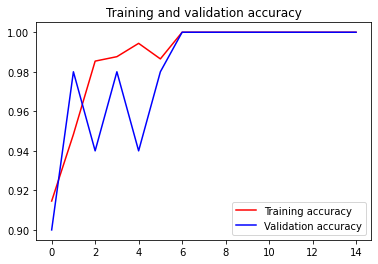

<Figure size 432x288 with 0 Axes>

In [31]:
%matplotlib inline
import matplotlib.pyplot as plt
acc = hist.history['accuracy']
val_acc = hist.history['val_accuracy']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()

plt.show()

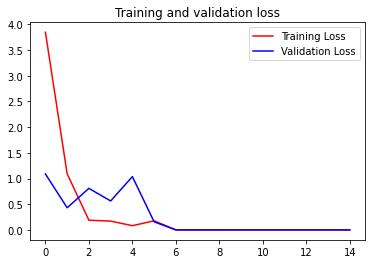

<Figure size 432x288 with 0 Axes>

In [32]:
loss = hist.history['loss']
val_loss = hist.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend(loc=0)
plt.figure()

plt.show()

In [33]:
model.evaluate(X_test, Y_test, batch_size=8)

30/30 [==============================] - 1s 24ms/step - loss: 0.4421 - accuracy: 0.9873


[0.44214293360710144, 0.9872881174087524]

In [34]:
y_pred = model.predict(X_test, batch_size=8)
y_pred[y_pred <= 0.5] = 0.
y_pred[y_pred > 0.5] = 1.

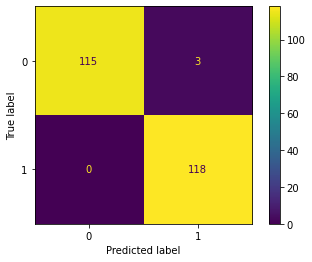

In [35]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(Y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

In [36]:
from sklearn.metrics import classification_report
print(classification_report(Y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      0.97      0.99       118
           1       0.98      1.00      0.99       118

    accuracy                           0.99       236
   macro avg       0.99      0.99      0.99       236
weighted avg       0.99      0.99      0.99       236

